In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
from skimage.metrics import peak_signal_noise_ratio#to calculate PSNR
from skimage.metrics import structural_similarity as ssim#to calculate SSIM
import deepinv as dinv

Path = Path("/data/aai/scratch/jchan/denoise/PAUS/dinggetest/simulation_laura/Flagship4ML/output_bright_for_error")

In [2]:
array1 = []
array2 = []
start = (120 - 96) // 2
end = start + 96

for ii in tqdm(range(20)):
    
    for band in np.arange(455, 855, 10):
        
        for exp in range(3):
            Path1 = Path / f"data_{ii}" / f"cutout_pau_nb{band}_exp{exp}.npy"
            Path2 = Path / f"data_{ii}" / f"clean_cutout_pau_nb{band}_exp{exp}.npy"
            
            data = np.load(Path1)
            data = data[:, start:end, start:end]
            
            data_clean = np.load(Path2)
            data_clean = data_clean[start:end, start:end]
            
            array1.append(data)
            array2.append(data_clean)
            
stamps_ori = np.stack(array1, axis=0)
stamps_cle = np.stack(array2, axis=0)

print(stamps_ori.shape)
print(stamps_cle.shape)

100%|██████████| 20/20 [02:59<00:00,  8.99s/it]


(2400, 30, 96, 96)
(2400, 96, 96)


In [3]:
import os
os.chdir('/data/aai/scratch/jchan/denoise/PAUS/dinggetest/simulation/pn2v/src/pn2v')
from unet import UNet

from core import utils
from core import training
from core import histNoiseModel
import torch
from core import prediction
device=utils.getDevice()

path='/data/aai/scratch/jchan/denoise/PAUS/dinggetest/simulation_laura/Flagship4ML/output'
net=torch.load(path+"/best_conv_N2V_lauras_simnobkg.net")

CUDA available? True


/tmp/ipykernel_433/435163719.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net=torch.load(path+"/best_conv_N2V_lauras_simnobkg.net")


In [4]:
#generate mask file for the annulus
mask_for_annulus = np.zeros((stamps_cle.shape[1], stamps_cle.shape[2]),dtype=bool)

x_inner, y_inner = 20, 76
x_outer, y_outer = 10, 86

mask_for_annulus[x_outer:y_outer, x_outer:y_outer] = True
mask_for_annulus[x_inner:y_inner, x_inner:y_inner] = False

#generate mask file for the images
maskFWHM = np.zeros((stamps_cle.shape[0], stamps_cle.shape[1], stamps_cle.shape[2]),dtype=bool)

for i in tqdm(range(len(maskFWHM))):
    bkg_value = np.median(stamps_cle[i][mask_for_annulus])
    max_value = np.max(stamps_cle[i])
    maskFWHM[i] = stamps_cle[i] > ( bkg_value + (max_value - bkg_value) / 2 )

#generate area file for the images, actually is the number of the pixel in the simulation
area = np.zeros((len(stamps_cle)))

for i in tqdm(range(len(area))):
    area[i] = np.sum(maskFWHM[i])

100%|██████████| 2400/2400 [00:00<00:00, 51144.33it/s]


In [5]:
stamps_ori_nobgk = stamps_ori.copy()
stamps_cle_nobgk = stamps_cle.copy()

for i in tqdm(range(len(stamps_ori))):
    for j in range(len(stamps_ori[0])):
        value_bkg = np.median(stamps_cle[i])
        stamps_ori_nobgk[i][j] = stamps_ori[i][j] - value_bkg
    stamps_cle_nobgk[i] = stamps_cle[i] - value_bkg

100%|██████████| 2400/2400 [00:20<00:00, 118.05it/s]


In [6]:
n2vResult = np.zeros((10, stamps_cle.shape[1], stamps_cle.shape[2]))

for i in tqdm(range(10)):
    n2vResult[i] = prediction.tiledPredict(stamps_ori_nobgk[i][0], net ,ps=96, overlap=48,
                                                device=device, noiseModel=None)

100%|██████████| 10/10 [00:00<00:00, 15.01it/s]


In [7]:
ssim_value = np.zeros((10))
ssim_value_pn2v = np.zeros((10))
psnr_value = np.zeros((10))
psnr_value_pn2v = np.zeros((10))
std_value = np.zeros((10))
std_value_pn2v = np.zeros((10))

for num in tqdm(range(10)):
    max_signal_peak = np.max(stamps_cle_nobgk[num])
    
    ssim_value[num] = ssim(stamps_cle_nobgk[num], 
                      stamps_ori_nobgk[num][0], 
                      data_range=max_signal_peak)
    
    ssim_value_pn2v[num] = ssim(stamps_cle_nobgk[num], 
                      n2vResult[num], 
                      data_range=max_signal_peak)
    
    psnr_value[num] = peak_signal_noise_ratio(stamps_cle_nobgk[num], 
                                         stamps_ori_nobgk[num][0], 
                                         data_range=max_signal_peak)
    
    psnr_value_pn2v[num] = peak_signal_noise_ratio(stamps_cle_nobgk[num], 
                                         n2vResult[num], 
                                         data_range=max_signal_peak)

    std_value[num] = np.std(stamps_ori_nobgk[num][0][mask_for_annulus])
    std_value_pn2v[num] = np.std(n2vResult[num][mask_for_annulus])

100%|██████████| 10/10 [00:00<00:00, 300.77it/s]


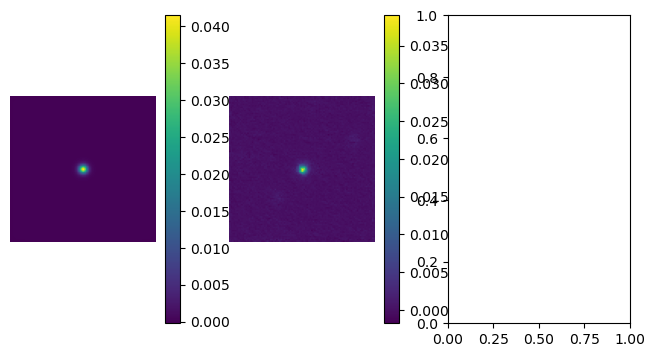

In [8]:
num = 0
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))  # 调整 figsize 以获得更好的可视化效果

axes = axes.flatten()

im1 = axes[0].imshow(stamps_cle_nobgk[num])
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(n2vResult[num])
axes[1].axis('off')
fig.colorbar(im2, ax=axes[1])

In [9]:
bm3d = dinv.models.BM3D()
tgv = dinv.models.TGVDenoiser()
wavelet = dinv.models.WaveletDictDenoiser()
sigma = 0.2

In [10]:
ori = stamps_ori_nobgk[0][0].copy()
ori = torch.from_numpy(ori)
ori = ori.unsqueeze(0)
ori = ori.unsqueeze(0).cuda()

cle = stamps_cle_nobgk[0].copy()
cle = torch.from_numpy(cle)
cle = cle.unsqueeze(0)
cle = cle.unsqueeze(0).cuda()


In [11]:
imgs = [
    cle,
    ori,
    bm3d(ori, sigma),
    tgv(ori, sigma),
    wavelet(ori, sigma),
]

psnr = [dinv.metric.cal_psnr(cle, im).item() for im in imgs[1:]]
titles = ["Original", "Noisy", "BM3D", "TGV", "Wavelet"]
subtitles = ["PSNR:"] + [f"{p:.2f} dB" for p in psnr]

plot_inset(
    img_list=imgs,
    titles=titles,
    subtitles=subtitles,
    #suptitle=rf"Noise level $\sigma={sigma:.2f}$",
    extract_size=0.2,
    extract_loc=(0.5, 0.0),
    inset_size=0.5,
    figsize=(len(imgs) * 1.5, 2.5),
)

NameError: name 'plot_inset' is not defined

In [ ]:
num = 0
max_signal_peak = np.max(stamps_cle_nobgk[num])
psnr_TGV = peak_signal_noise_ratio(stamps_cle_nobgk[num], imgs[3].cpu().squeeze().numpy(), data_range=max_signal_peak)
psnr_Wavelet = peak_signal_noise_ratio(stamps_cle_nobgk[num], imgs[4].cpu().squeeze().numpy(), data_range=max_signal_peak)
psnr_BM3D = peak_signal_noise_ratio(stamps_cle_nobgk[num], imgs[2].cpu().squeeze().numpy(), data_range=max_signal_peak)

ssim_TGV = ssim(stamps_cle_nobgk[num], imgs[3].cpu().squeeze().numpy(), data_range=max_signal_peak)
ssim_Wavelet = ssim(stamps_cle_nobgk[num], imgs[4].cpu().squeeze().numpy(), data_range=max_signal_peak)
ssim_BM3D = ssim(stamps_cle_nobgk[num], imgs[2].cpu().squeeze().numpy(), data_range=max_signal_peak)

std_TGV = np.std(imgs[3].cpu().squeeze().numpy()[mask_for_annulus])
std_Wavelet = np.std(imgs[4].cpu().squeeze().numpy()[mask_for_annulus])
std_BM3D = np.std(imgs[2].cpu().squeeze().numpy()[mask_for_annulus])

print(psnr_TGV)
print(psnr_Wavelet)
print(psnr_BM3D)

print(ssim_TGV)
print(ssim_Wavelet)
print(ssim_BM3D)

print(std_TGV)
print(std_Wavelet)
print(std_BM3D)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(12, 4)) 
axes = axes.flatten()

sub_texts = [
    " ", #  Ground true
    "PSNR: 8.67 dB \nSSIM: 7.35e-03", #  Noisy
    "PSNR: 38.32 dB \nSSIM: 0.9", #  PN2V
    "PSNR: 30.69 dB \nSSIM: 0.46", #  TGV
    "PSNR: 27.15 dB \nSSIM: 0.23", #  Wavelet
    "PSNR: 29.44 dB \nSSIM: 0.97"  #  BM3D
]


im1 = axes[0].imshow(stamps_cle_nobgk[0])
axes[0].set_title('Noiseless', fontsize=12)
axes[0].axis('off')
axes[0].text(0.5, -0.15, sub_texts[0], transform=axes[0].transAxes,
             ha='center', va='top', fontsize=9, linespacing=1.5)

im2 = axes[1].imshow(stamps_ori_nobgk[0][0])
axes[1].set_title('Noisy', fontsize=12)
axes[1].axis('off')
axes[1].text(0.5, -0.15, sub_texts[1], transform=axes[1].transAxes,
             ha='center', va='top', fontsize=9, linespacing=1.5)

im3 = axes[2].imshow(n2vResult[0])
axes[2].set_title('PN2V', fontsize=12)
axes[2].axis('off')
axes[2].text(0.5, -0.15, sub_texts[2], transform=axes[2].transAxes,
             ha='center', va='top', fontsize=9, linespacing=1.5)

im4 = axes[3].imshow(imgs[3].cpu().squeeze().numpy())
axes[3].set_title('TGV', fontsize=12)
axes[3].axis('off')
axes[3].text(0.5, -0.15, sub_texts[3], transform=axes[3].transAxes,
             ha='center', va='top', fontsize=9, linespacing=1.5)

im5 = axes[4].imshow(imgs[4].cpu().squeeze().numpy())
axes[4].set_title('Wavelet', fontsize=12)
axes[4].axis('off')
axes[5].text(0.5, -0.15, sub_texts[4], transform=axes[4].transAxes,
             ha='center', va='top', fontsize=9, linespacing=1.5)

im6 = axes[5].imshow(imgs[2].cpu().squeeze().numpy())
axes[5].set_title('BM3D', fontsize=12)
axes[5].axis('off')
axes[5].text(0.5, -0.15, sub_texts[5], transform=axes[5].transAxes,
             ha='center', va='top', fontsize=9, linespacing=1.5)

plt.subplots_adjust(bottom=0.2) 
#plt.savefig("/data/aai/scratch/jchan/denoise/PAUS/output_save/Baselines.pdf",
           # format="pdf", bbox_inches="tight")
plt.show()


In [74]:
stamps_cle_nobgk[6].max()

0.05036708133827661

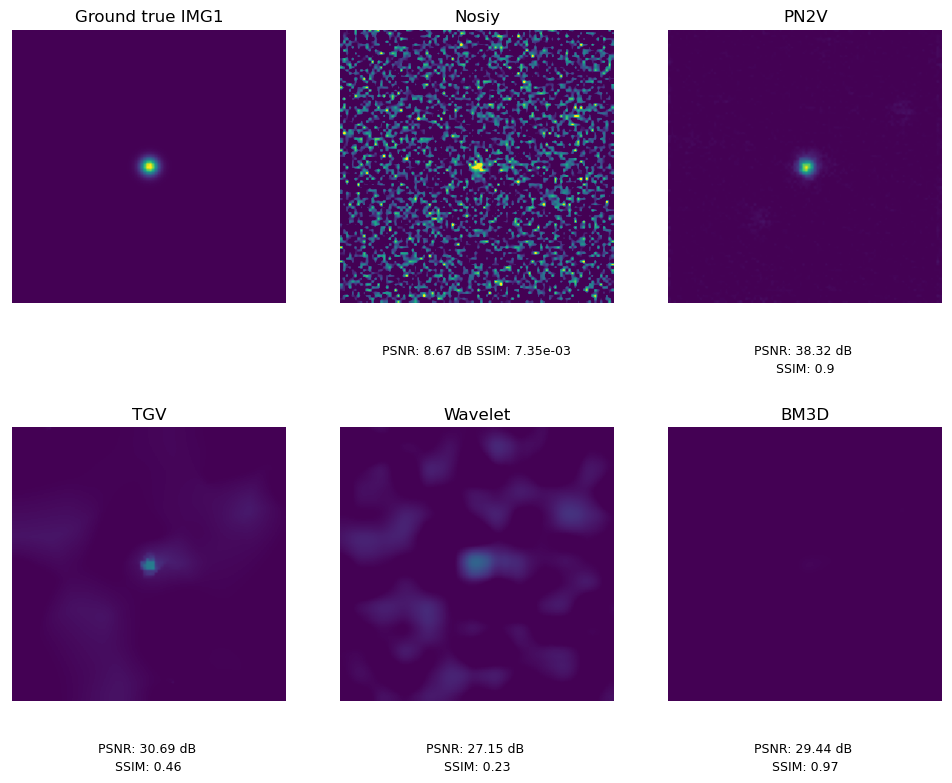

In [81]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8)) 
axes = axes.flatten()

sub_texts = [
    " ", #  Ground true
    "PSNR: 8.67 dB SSIM: 7.35e-03", #  Noisy
    "PSNR: 38.32 dB \nSSIM: 0.9", #  PN2V
    "PSNR: 30.69 dB \nSSIM: 0.46", #  TGV
    "PSNR: 27.15 dB \nSSIM: 0.23", #  Wavelet
    "PSNR: 29.44 dB \nSSIM: 0.97"  #  BM3D
]

img_data_list = [
    stamps_cle_nobgk[0],
    stamps_ori_nobgk[0][0],
    n2vResult[0],
    imgs[3].cpu().squeeze().numpy(),
    imgs[4].cpu().squeeze().numpy(),
    imgs[2].cpu().squeeze().numpy()
]


vmin = 0
vmax = 0.04

im1 = axes[0].imshow(img_data_list[0], vmin=vmin, vmax=vmax)
axes[0].set_title('Ground true IMG1', fontsize=12)
axes[0].axis('off')
axes[0].text(0, 0, sub_texts[0], transform=axes[0].transAxes,
             ha='center', va='top', fontsize=9, linespacing=0)

im2 = axes[1].imshow(img_data_list[1], vmin=vmin, vmax=vmax)
axes[1].set_title('Nosiy', fontsize=12)
axes[1].axis('off')
axes[1].text(0.5, -0.15, sub_texts[1], transform=axes[1].transAxes,
             ha='center', va='top', fontsize=9, linespacing=1.5)

im3 = axes[2].imshow(img_data_list[2], vmin=vmin, vmax=vmax)
axes[2].set_title('PN2V', fontsize=12)
axes[2].axis('off')
axes[2].text(0.5, -0.15, sub_texts[2], transform=axes[2].transAxes,
             ha='center', va='top', fontsize=9, linespacing=1.5)

# --- Row 1 (逻辑上的) ---
im4 = axes[3].imshow(img_data_list[3], vmin=vmin, vmax=vmax)
axes[3].set_title('TGV', fontsize=12)
axes[3].axis('off')
axes[3].text(0.5, -0.15, sub_texts[3], transform=axes[3].transAxes,
             ha='center', va='top', fontsize=9, linespacing=1.5)

im5 = axes[4].imshow(img_data_list[4], vmin=vmin, vmax=vmax)
axes[4].set_title('Wavelet', fontsize=12)
axes[4].axis('off')
# (已更正: axes[4] -> axes[1, 1])
axes[4].text(0.5, -0.15, sub_texts[4], transform=axes[4].transAxes,
             ha='center', va='top', fontsize=9, linespacing=1.5)

im6 = axes[5].imshow(img_data_list[5], vmin=vmin, vmax=vmax)
axes[5].set_title('BM3D', fontsize=12)
axes[5].axis('off')
axes[5].text(0.5, -0.15, sub_texts[5], transform=axes[5].transAxes,
             ha='center', va='top', fontsize=9, linespacing=1.5)

plt.subplots_adjust(bottom=0, hspace=0.3) 
#plt.savefig("/data/aai/scratch/jchan/denoise/PAUS/output_save/Baselines.pdf",
#            format="pdf", bbox_inches="tight")
plt.show()

In [12]:
import time

import torch
import pandas as pd
import matplotlib.pyplot as plt

import deepinv as dinv
from deepinv.utils.plotting import plot_inset
from deepinv.utils.demo import load_example
from deepinv.utils.compat import zip_strict

/data/aai/scratch/jchan/miniconda3/envs/denoise/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1730827426462/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/data/aai/scratch/jchan/miniconda3/envs/denoise/lib/python3.12/site-packages/deepinv/utils/plotting.py:379: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(top=0.75)


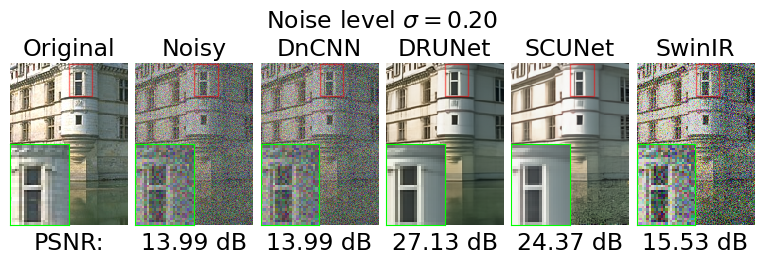

In [23]:
dncnn = dinv.models.DnCNN()
drunet = dinv.models.DRUNet()
swinir = dinv.models.SwinIR()
scunet = dinv.models.SCUNet()

imgs = [
    image,
    noisy_image,
    dncnn(noisy_image, sigma),
    drunet(noisy_image, sigma),
    scunet(noisy_image, sigma),
    swinir(noisy_image, sigma),
]
titles = [
    "Original",
    "Noisy",
    "DnCNN",
    "DRUNet",
    "SCUNet",
    "SwinIR",
]
psnr = [dinv.metric.cal_psnr(image, im).item() for im in imgs[1:]]
subtitles = ["PSNR:"] + [f"{p:.2f} dB" for p in psnr]

plot_inset(
    img_list=imgs,
    titles=titles,
    subtitles=subtitles,
    suptitle=rf"Noise level $\sigma={sigma:.2f}$",
    extract_size=0.2,
    extract_loc=(0.5, 0.0),
    inset_size=0.5,
    figsize=(len(imgs) * 1.5, 2.5),
)